In [1]:
from skimage.filters import gaussian
import math
from skimage.draw import ellipse
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

from keras import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [12]:
def show(img):
    if len(img.shape) == 3:
        height, width,_ = img.shape
    elif len(img.shape) == 2:
        height, width = img.shape
        
    img = img.reshape(height, width)
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap='gray')
    plt.show()
    
def rgb2gray(img):
    return (0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]).astype('float32')

In [3]:
def noisy(image):
    row,col= image.shape
    s_vs_p = 0.5
    amount = 0.004
    
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return out

In [4]:
def get_spectr(size):
    spectr = np.ones(size, dtype='float32')
    height, width = size
    pos = np.random.randint(int(0.25*height), int(0.75*height))
    start_pos = np.random.randint(0, int(0.15*width))
    min_spectr_width = np.random.randint(2,7)
    spectr_width = np.random.randint(min_spectr_width, 2*min_spectr_width, width-start_pos)
    
    for j in range(start_pos, width):
        spectr[pos-spectr_width[j-start_pos]:pos+spectr_width[j-start_pos], j] = \
        np.zeros((2*spectr_width[j-start_pos],))
    
    n_features = np.random.randint(0,4)
    features_coords = np.random.randint(start_pos+50, width-50, n_features)
    features_height = np.random.randint(15,25,n_features)
    features_width = np.random.randint(5,9,n_features)
    
    for i in range(n_features):
        spectr[pos-features_height[i]:pos+features_height[i], 
               features_coords[i]-features_width[i]:features_coords[i]+features_width[i]] = \
               np.zeros((2*features_height[i], 2*features_width[i]))
    
    spectr = gaussian(spectr, sigma=3.5)
    mask = np.where(spectr < 0.8, 0, 1)
    return spectr, mask

def get_pair(size):
    r,g,b = np.random.randint(190,210,3)
    r = np.random.randint(r, r+10, size)
    g = np.random.randint(g, g+10, size)
    b = np.random.randint(b, b+10, size)
    img = np.stack((r,g,b), axis=2).astype('float32')
    img = rgb2gray(img)/255
    img = noisy(img)
    
    spectr, mask = get_spectr(size)
    img = np.where(mask, img, spectr)
    
    n_lines = np.random.randint(10,30)
    lines_width = np.random.randint(1,3, n_lines)
    lines_coords = np.random.randint(int(size[1]*0.02), int(size[1]*0.98), n_lines)
    
    for i in range(n_lines):
        img[:,lines_coords[i]-lines_width[i]:lines_coords[i]+lines_width[i]] = \
        np.zeros((size[0], 2*lines_width[i]))
        
    radius_max = 20
    radius_min = 10
    
    r = np.random.randint(int(0.1*size[0]), int(0.9*size[0]))
    c = np.random.randint(int(0.1*size[1]), int(0.9*size[1]))
    r_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    c_radius = np.random.sample()*(radius_max-radius_min) + radius_min
    
    rot = np.random.sample()*360
    rr, cc = ellipse(r, c, 2*r_radius, 0.2*c_radius, rotation=np.deg2rad(rot), shape=img.shape)
        
    img[rr,cc] = 0
    
    return img.reshape(size[0],size[1],1), mask.reshape(size[0],size[1],1)

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


get_custom_objects().update({'dice_coef': dice_coef })

In [6]:
def build_model(height, width, start_neurons):
    input_layer = Input((height, width, 1))
    
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(input_layer, output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=[dice_coef])
#     model.save_weights('./keras.weights')
    return model

In [7]:
height, width = 400,1408
data_dir = 'data/preprocessing_2/'

In [8]:
model = build_model(height, width, 16)
model.load_weights('preprocessing.hdf5')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
test_num = 3
test_x = np.zeros((test_num, height, width,1), dtype='float32')
test_y = np.zeros((test_num, height, width,1), dtype='float32')


for k in range(test_num):
    img, msk = get_pair((height, width))
    
    test_x[k] = img
    test_y[k] = msk

predicted_masks = np.around(model.predict(test_x))

/Users/george/opt/anaconda3/envs/coursework/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
/Users/george/opt/anaconda3/envs/coursework/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [10]:
test_filenames = ['test_01.png', 'test_02.png', 'test_03.png']
mask_filenames = ['mask_01.png', 'mask_02.png', 'mask_03.png']
predicted_filenames = ['predicted_01.png', 'predicted_02.png', 'predicted_03.png']

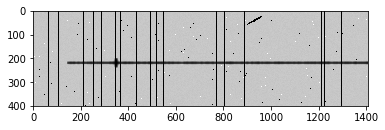

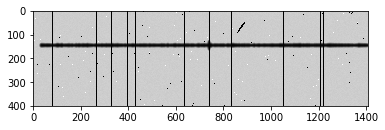

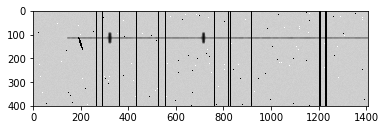

In [13]:
for i in range(test_num):
    show(test_x[i])
    plt.imsave(join(data_dir, test_filenames[i]), test_x[i].reshape(height, width), cmap = plt.cm.gray)

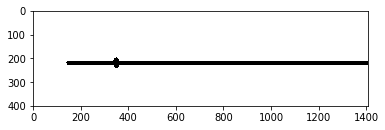

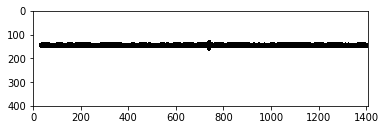

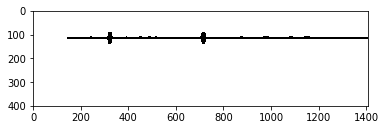

In [14]:
for i in range(test_num):
    show(predicted_masks[i])
    plt.imsave(join(data_dir, predicted_filenames[i]), predicted_masks[i].reshape(height, width), cmap = plt.cm.gray)

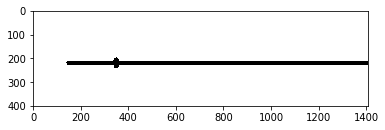

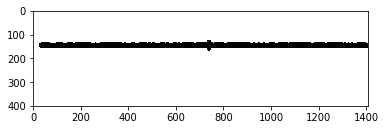

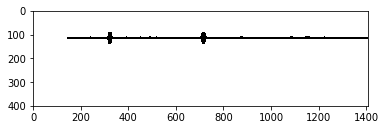

In [15]:
for i in range(test_num):
    show(test_y[i])
    plt.imsave(join(data_dir, mask_filenames[i]), test_y[i].reshape(height, width), cmap = plt.cm.gray)

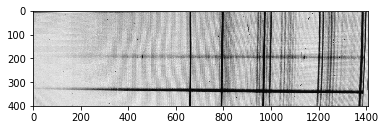

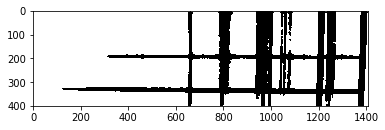

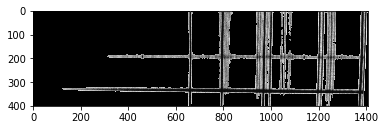

In [23]:
# from skimage.transform import resize
# from skimage.io import imread

# img = resize(rgb2gray(imread(join(data_dir, 'photo.jpg'))), (height, width))/255.
# predicted = np.around(model.predict(img.reshape(1, height, width, 1))).reshape(height, width)
# transformed = img*(1-predicted)
# show(img)
# show(predicted)
# show(transformed)
# plt.imsave(join(data_dir, 'photo_predicted.png'), predicted, cmap = plt.cm.gray)
# plt.imsave(join(data_dir, 'photo_transformed.png'), transformed, cmap = plt.cm.gray)